<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/Summarization_test_REFERENCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Summarization Tests

**Description:** This assignment covers summarization outputs. You will compare three different types of solutions, all using an encoder decoder architecture. You should also be able to develop an intuition for:


* How well summarization systems work
* The effects of using different pre-training and fine-tuning checkpoints on outcomes
* The effects of hyperparameters on outcomes
* Evaluation of output using ROUGE



This notebook should be run on a Google Colab but it does not require a GPU. By default, when you open the notebook in Colab it will NOT configure a GPU.  Summarization commands can take up to five minutes to run depending on the hyperparameters you use. This notebook will NOT run on your GCP instance as the summary models are larger than the avaialble memory.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2023-spring-main/blob/master/assignment/a3/Summarization_test.ipynb)

The overall assignment structure is as follows:

 Setup

1. T5 for generic summarization

2. Pegasus for headline summarization

3. Pegasus for longer generation




**INSTRUCTIONS:**: 

* Questions are always indicated as **QUESTION:**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1 and a2.

* **### YOUR CODE HERE** indicates that you are supposed to write code.




## Setup

In [ ]:
!pip install -q sentencepiece

In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q evaluate
import evaluate

[ROUGE](https://pypi.org/project/rouge-score/): a Package for Automatic Evaluation of Summaries.

In [ ]:
!pip install -q rouge_score

[pprint — Data pretty printer](https://docs.python.org/3/library/pprint.html#module-pprint):

The **pprint** module provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter. 

In [ ]:
# let's make longer output readable without horizontal scrolling
from pprint import pprint

Let's leverage the pre-trained and fine tuned models on HuggingFace to demonstrate some capabilities with abstractive summarization and language generation.  They include models/checkpoints that were fine tuned on a particular dataset.  In our case we'll focus on one dataset that emphasizes a one line output and another that emphasizes a multi-line output.   

We'll use this same toy article as the input to all of our summarization attempts.  That way we have the ability to compare. We'll also create two references for evaluation.  These are the targets you are trying to meet.  One reference is for the longer output. The second reference is the short one for the one line output.

In [ ]:
# Input (ARTICLE_TO_SUMMARIZE)
ARTICLE_TO_SUMMARIZE = (
    "Nearly 800 thousand customers are scheduled to be affected by the shutoffs which are expected to last through at least midday tomorrow. "
    "PG&E stated it scheduled the blackouts in response to forecasts for high winds amid dry conditions. "
    "The aim is to reduce the risk of wildfires. "
    "If Pacific Gas & Electric Co, a unit of PG&E Corp, goes through with another public safety power shutoff, "
    " it would be the fourth round of mass blackouts imposed by the utility since Oct. 9, when some 730,000 customers were left in the dark. "
    "The recent wave of precautionary shutoffs have drawn sharp criticism from Governor Gavin Newsom, state regulators and consumer activists as being overly broad in scale."
    "Newsom blames PG&E for doing too little to properly maintain and secure its power lines against wind damage."
    "Utility executives have acknowledged room for improvement while defending the sprawling scope of the power cutoffs as a matter of public safety."
    "The record breaking drought has made the current conditions even worse than in previous years. "
    "It exponentially increases the probability of large scale wildfires. "
)

# Two target outputs - 1) Longer Output (LONG_REFERENCE) or 2) Shorter Output (SHORT_REFERENCE)
LONG_REFERENCE = (
    "Many PG&E customers could be affected by public safety power shutoffs in response to forecasts for high winds and dry conditions. "
    "The record breaking drought exponentially increases the probability of large scale wildfires. "
    "Despite being criticized by Governor Newsom for being overly broad, company officials defend the cutoffs as a matter of public safety. "
)

SHORT_REFERENCE = (
    "California's largest utility is set to turn off power to hundreds of thousands of customers in an effort to reduce the risk of wildfires. "
)

How long is our article to summarize?  Obviously our summary should be shorter since it is supposed to be "abridged."

In [ ]:
print(f'num_tokens_ARTICLE_TO_SUMMARIZE: {len(str.split(ARTICLE_TO_SUMMARIZE))}\nnum_tokens_LONG_REFERENCE: {len(str.split(LONG_REFERENCE))}\nnum_tokens_SHORT_REFERENCE: {len(str.split(SHORT_REFERENCE))}')

num_tokens_ARTICLE_TO_SUMMARIZE: 177
num_tokens_LONG_REFERENCE: 54
num_tokens_SHORT_REFERENCE: 24


## 1. T5 for Generic Summarization

T5 is an encoder decoder architecture that has been trained on multiple tasks, so not purely summarization.  You can read more about it [here](https://huggingface.co/docs/transformers/model_doc/t5).

In [ ]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration

t5model = TFT5ForConditionalGeneration.from_pretrained("t5-base")
t5tokenizer = T5Tokenizer.from_pretrained("t5-base")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this wa

In [ ]:
t5model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  109628544 
                                                                 
 decoder (TFT5MainLayer)     multiple                  137949312 
                                                                 
Total params: 222,903,552
Trainable params: 222,903,552
Non-trainable params: 0
_________________________________________________________________


Since T5 can perform multiple tasks we need to tell it what kind of output we want.  Therefore we need to prepend a "prompt" to our article text to make sure it does the right thing.

In [ ]:
PROMPT = 'summarize: '
T5ARTICLE_TO_SUMMARIZE = PROMPT + ARTICLE_TO_SUMMARIZE

In [ ]:
inputs = t5tokenizer(T5ARTICLE_TO_SUMMARIZE, max_length=1024, truncation=True, return_tensors="tf")

What do the inputs look like?  How does it compare with what we've seen from BERT?

In [ ]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 241), dtype=int32, numpy=
array([[21603,    10, 10455,   120,  8640,  7863,   722,    33,  5018,
           12,    36,  4161,    57,     8,  6979,  1647,     7,    84,
           33,  1644,    12,   336,   190,    44,   709,  2076,  1135,
         5721,     5,     3,  7861,   184,   427,  4568,    34,  5018,
            8,  1001,   670,     7,    16,  1773,    12,  7555,     7,
           21,   306, 13551, 18905,  2192,  1124,     5,    37,  2674,
           19,    12,  1428,     8,  1020,    13,  3645,  6608,     7,
            5,   156,  5824,  6435,     3,   184,  8666,   638,     6,
            3,     9,  1745,    13,     3,  7861,   184,   427, 10052,
            6,  1550,   190,    28,   430,   452,  1455,   579,  6979,
         1647,     6,    34,   133,    36,     8,  4509,  1751,    13,
         3294,  1001,   670,     7,     3, 16068,    57,     8,  6637,
          437,  6416,     5,  9902,   116,   128,   489, 17093,   722,
          130, 

Let's just run T5 using it's default hyperparameters and see what happens.  We'll hold on to the output in the candidate variable.  What do you think about the output?

In [ ]:
# Generate Summary
summary_ids = t5model.generate(inputs["input_ids"], )

candidate = t5tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

pprint(candidate[0], compact=True)

/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:702: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'PG&e shuts off power to 800 thousand customers . the shutoffs are'


### 1.a Checkpoint Configuration

We're using the `t5-base` configuration and we know we can run out of the box to do summarization which means it has some hyperparameters set as defaults.  These may or may not be what we want to use.  How do we know which values are set as defaults?

HuggingFace provides **access to the default hyperparameters via the AutoConfig** object which we call below.  We simply pass in the name of the checkpoint we're using -- `t5-base` in this case.

Default values i.e.: <br>
  ```"task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },```


In [ ]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained("t5-base")

config

T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "pre

Look at the `task_specific_params` for summarization. You can see that this `t5-base` checkpoint has some values such as **min_length** and **max_lengthv as well as **no_repeat_ngram_size** and **num_beams**.  You can affect the size and content of the output by modifying these parameters which you will do below.

You can also look at the full set of possible parameters in the [TFGenerationMixin](https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/text_generation#transformers.generation_tf_utils.TFGenerationMixin) class available to all of the pre-trained models.

HuggingFace has also written [a very helpful blog post](https://huggingface.co/blog/how-to-generate) that explains and discusses various strategies for text generation and how to manipulate the hyperparameters.  They discuss the two approaches of **beam search** (which we have discussed in the async and live session) as well as sampling (which tries to **randomly pick the next word within a k-sized distribution of highly probable choices**).  

**Please read the blog post before you proceed.**

For your reference, here's a more complex, technical, and thorough [HuggingFace guide](https://huggingface.co/docs/transformers/main/en/generation_strategies) for controlling generation of text.  The blog post above is all you need to read to complete the assignment.

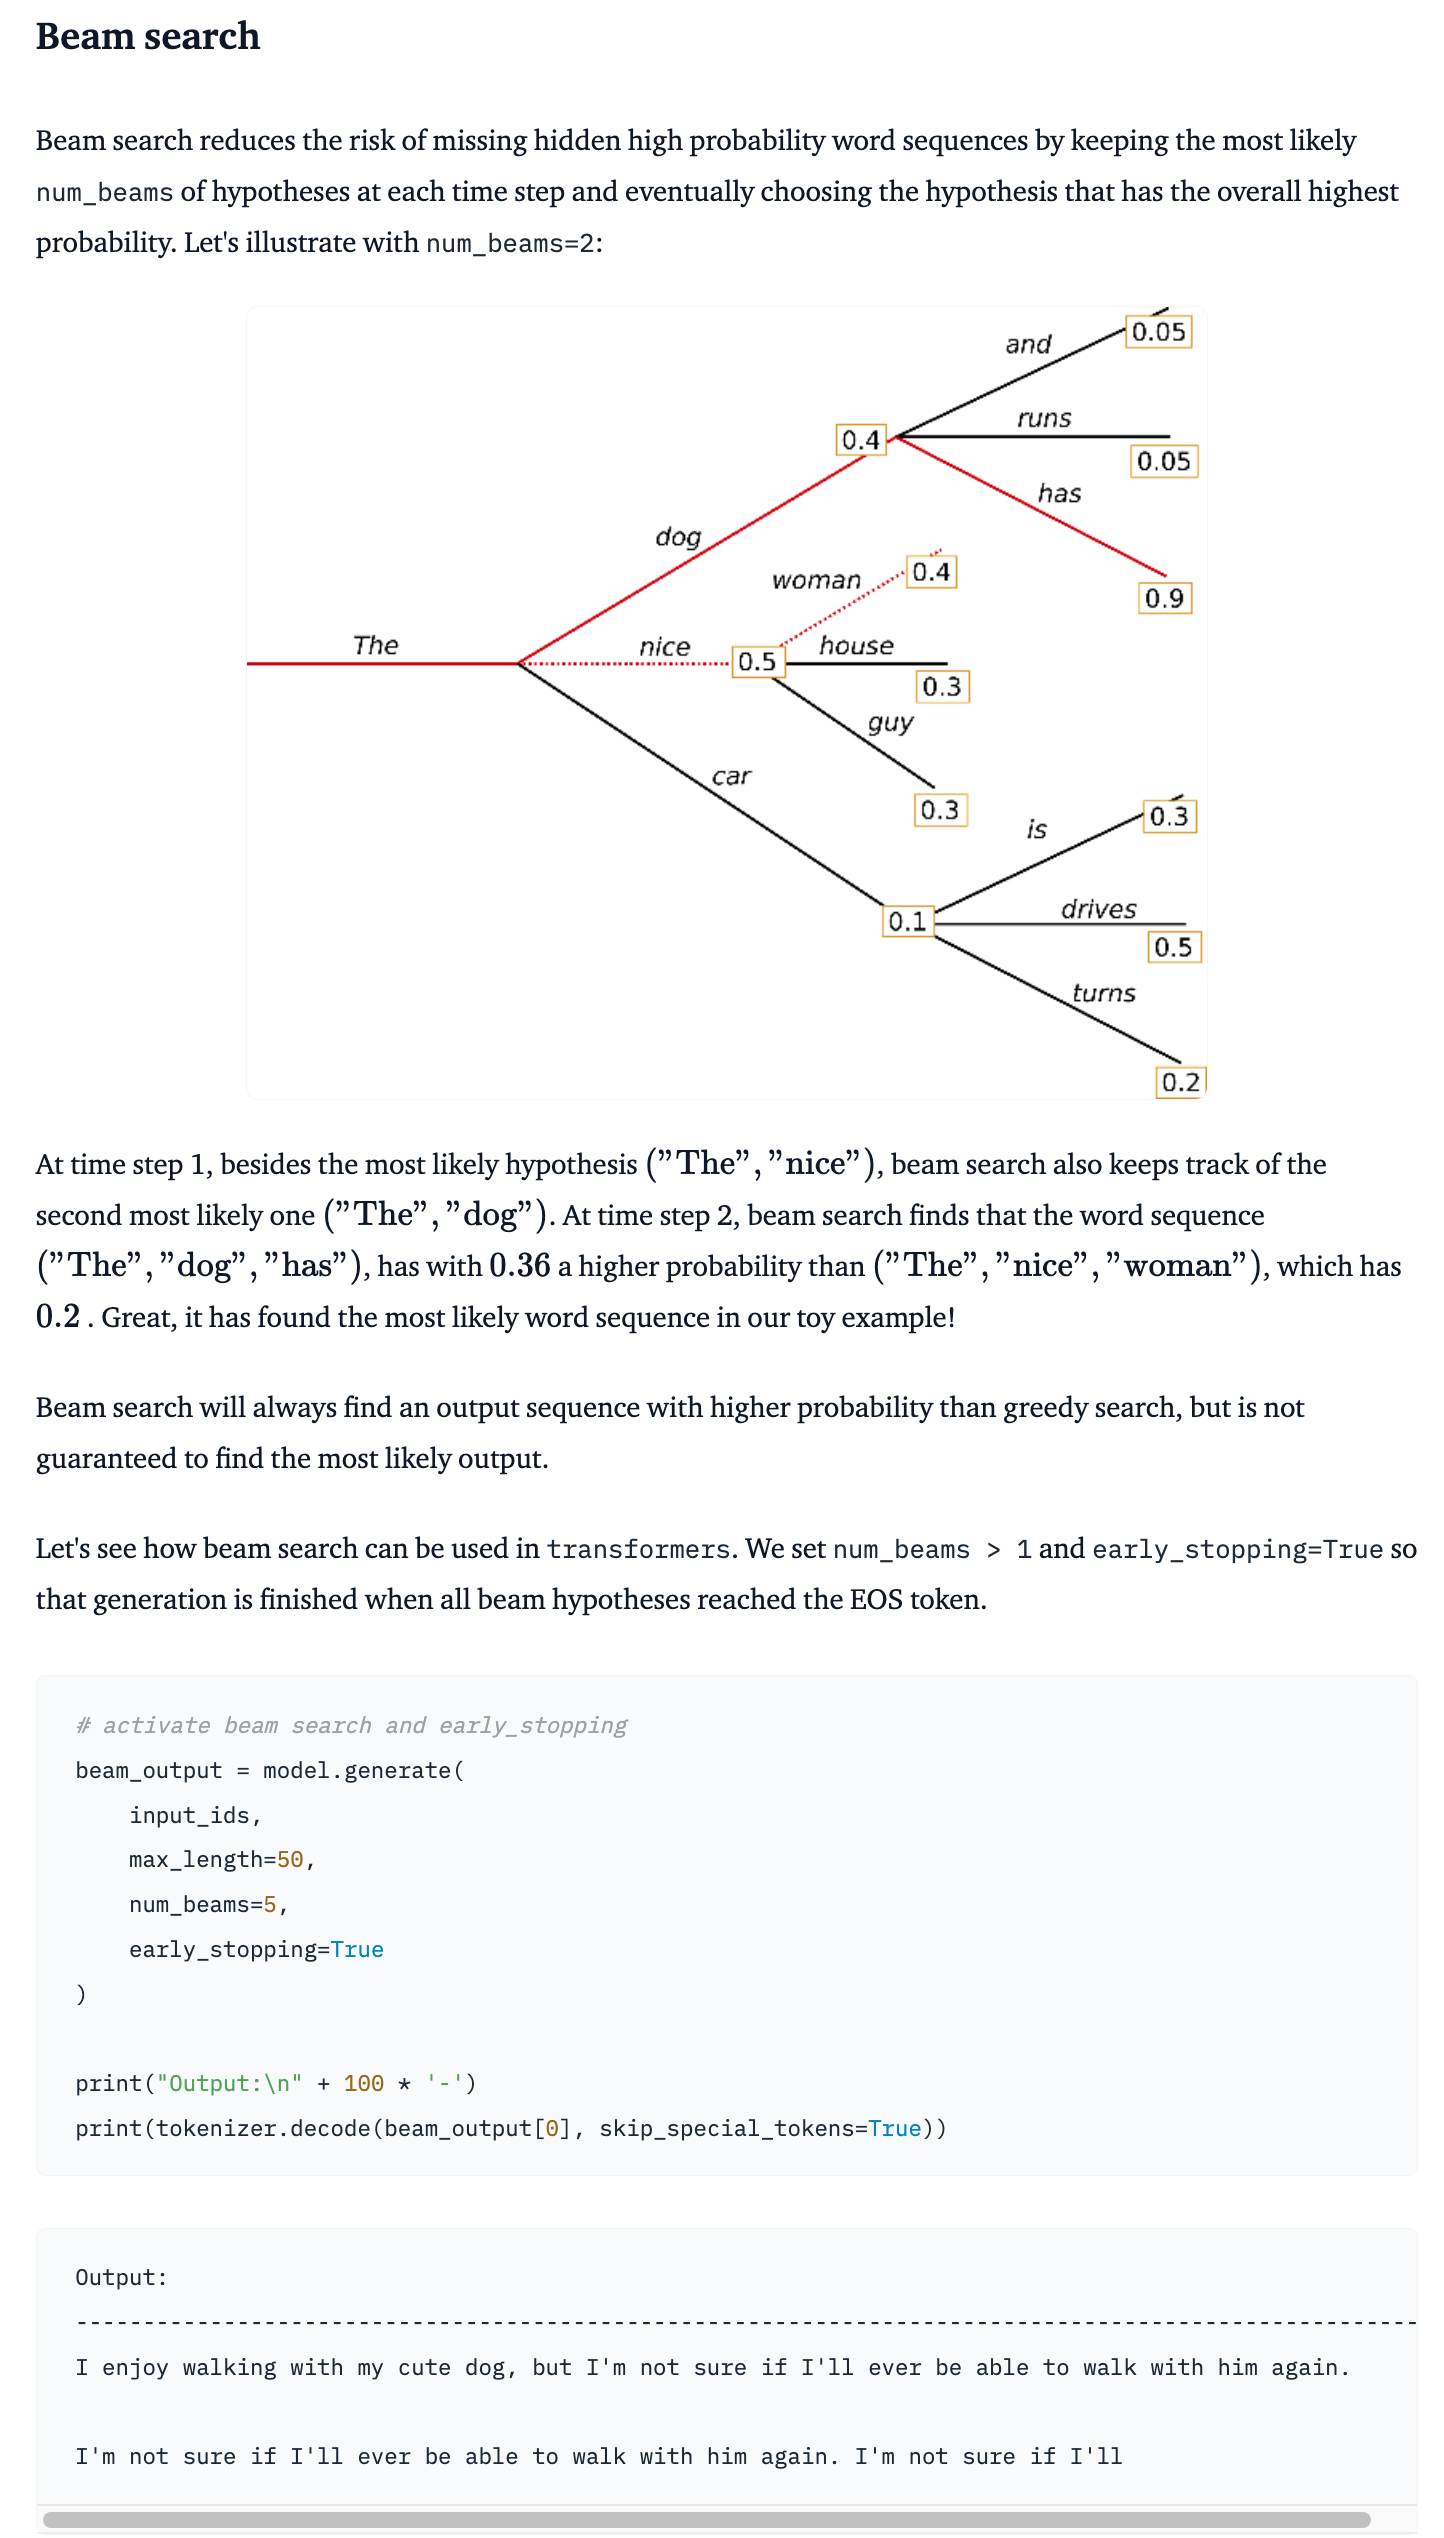

### 1.b ROUGE for summarization evaluation

**ROUGE** is the **metric that has been traditionally used to evaluate sumarization results**.  The ROUGE metric **expects a reference as input** and it will **evaluate a candidate (model-produced) against that reference (human-produced)**.  
- **ROUGE-1** (unigram-based scoring): calculates the **number of words in the reference that occur in the candidate**.  
- **ROUGE-2**(bigram-based scoring): performs that same calculation but for **bigrams in the reference**. 
- **ROUGE-L**: calculates the **longest common subsequence of reference words that occur in the candidate**.

HuggingFace provides a wrapper around [a library](https://huggingface.co/spaces/evaluate-metric/rouge) to calculate ROUGE metrics which you will use below.  Let's calculate the ROUGE score for the candidate you produced above.

In [ ]:
summary_ids = t5model.generate(inputs["input_ids"], )
candidate = t5tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(candidate[0], compact=True)

'PG&e shuts off power to 800 thousand customers . the shutoffs are'


In [ ]:
# summary_ids = t5model.generate(inputs["input_ids"], )
# candidate = t5tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
# pprint(candidate[0], compact=True)
# ======================================
# SHORT_REFERENCE = ("California's largest utility is set to turn off power to hundreds of thousands of customers in an effort to reduce the risk of wildfires. ")
# ======================================
# PROMPT = 'summarize: '
# T5ARTICLE_TO_SUMMARIZE = PROMPT + ARTICLE_TO_SUMMARIZE
# inputs = t5tokenizer(T5ARTICLE_TO_SUMMARIZE, max_length=1024, truncation=True, return_tensors="tf")

In [ ]:
rouge = evaluate.load('rouge')
predictions = candidate
references = [SHORT_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.2702702702702703, 'rouge2': 0.1142857142857143, 'rougeL': 0.2702702702702703, 'rougeLsum': 0.2702702702702703}


[.batch_decode()](https://huggingface.co/docs/transformers/internal/tokenization_utils):<br>
Returns a list of strings. Convert a list of lists of token_ids into a list of strings by calling decode.

Let's experiment with the hyperparameters shown above.  Please experiment in the cell below.  
- The `num_beams` value is like a beam search.  It indicates the number of tries the model makes before showing you its best output.  
- The `no_repeat_ngram_size` is designed to help reduce repetition in the output.  
- `min_length` and `max_length` set boundaries on the size of the summary. You are free to use other hyperparameters as described in the [blog post](https://huggingface.co/blog/how-to-generate).

*There is no one correct answer to these questions.  There are ranges that tend to work better than others.  The goal is to have you experiment to help build intuition.  Please enter the values that you think are generating the most readable output.* 

*Your readable output should consist of at least one complete sentence but does not have to end with a period and you must also have a ROUGE-1 score above 0.30 and ROUGE-L score equal to or above 0.25 when compared with the short reference.*

You can use the two cells below to come up with your answer.

**Question for OH:** do we need to consider max or min of min_length to get the most readable output? Peter Responsed: we want to use lower values for the hyperparams in real world practice as it's computationally cheaper but for this HW, we are fine as long as getting the scores meeting the criteria (2/21/2023)

In [ ]:
# Generate Summary
summary_ids = t5model.generate(inputs["input_ids"],                                
### YOUR CODE HERE             
                               num_beams=3,
                              #  length_penalty=1.5,
                               no_repeat_ngram_size=3,
                               # num_return_sequences=3,     # to get 3 independently sampled outputs
                               min_length=20,    # the same result whether the min_length = 10 or 20
                               max_length=40     
### END YOUR CODE                
)

candidate = t5tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(candidate[0], compact=True)

('PG&e shuts off power to 800 thousand customers in response to forecasts for '
 'high winds . the aim is to reduce the risk of wildfires .')


When you do have a little bit longer min and max squence length, you will get a little better complete summary. Of course, you don't want it to be as long as the input, then it wouldn't be summarizing. It would not be useful for the task purpose.

In [ ]:
# num_tokens_SHORT_REFERENCE: 24
# num_tokens_ARTICLE_TO_SUMMARIZE: 177  => the length of input sequence (num of tokens)

predictions = candidate
references = [SHORT_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.52, 'rouge2': 0.3333333333333333, 'rougeL': 0.44, 'rougeLsum': 0.44}


**QUESTION:**

1.1 What num_beams value gives you the most readable output that meets the score criteria? **3**

1.2 Which no_repeat_ngram_size gives the most readable output that meets the score criteria? **3**

1.3 What min_length value gives you the most readable output that meets the score criteria? **20**

1.4 Which max_length value gives the most readable output that meets the score criteria? **40**

In [ ]:
#In order to not consume all of the memory available in Colab we'll free up the memory we're using for these large language models
del t5model
del t5tokenizer 


## 2. Pegasus for Headline Summarization 

**Pegasus** is an **encoder decoder architecture that has been explicitly pre-trained as an abstractive summarizer**.  You can read more about it [here](https://huggingface.co/docs/transformers/model_doc/pegasus) and [here](https://arxiv.org/pdf/1912.08777.pdf).

We'll first use the `google/pegasus-xsum` checkpoint.  It is trained on a [summarization task](https://aclanthology.org/D18-1206.pdf) that reads a news article and then [emits (산출하다) a one line summary](https://huggingface.co/datasets/xsum).  This doesn't mean that it is limited in its output length.  It does mean that it works well with news article type inputs and tends toward shorter outputs.

In [ ]:
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration

pmodel = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
ptokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pmodel.summary()

Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFPegasusMainLayer)  multiple                  569748480 
                                                                 
 final_logits_bias (BiasLaye  multiple                 96103     
 r)                                                              
                                                                 
Total params: 569,844,583
Trainable params: 569,748,480
Non-trainable params: 96,103
_________________________________________________________________


Let's see what kinds of default parameters are configured in to this checkpoint.

In [ ]:
config = AutoConfig.from_pretrained("google/pegasus-xsum")

config

PegasusConfig {
  "_name_or_path": "google/pegasus-xsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 0,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,


Generate the inputs using the pegasus tokenizer for this checkpoint.

In [ ]:
inputs = ptokenizer(ARTICLE_TO_SUMMARIZE, max_length=1024, truncation=True, return_tensors="tf")

Let's get some output using just the default values and see what we're working with.

In [ ]:
# Generate Summary
summary_ids = pmodel.generate(inputs["input_ids"] 
)
pprint(ptokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0], compact=True)

/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:702: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


("California's largest utility has announced plans to cut power to hundreds of "
 'thousands of customers in a bid to reduce the risk of wildfires.')


Let's experiment with the same set of hyperparameters for the Let's experiment with the same set of hyperparameters for the Pegasus system.  It is designed for abstractive summarization. Remember that the checkpoint we are using was trained on data that generates a one line summary for the input article.
 system.  It is designed for abstractive summarization. Remember that the checkpoint we are using was trained on data that generates a one line summary for the input article.

*Your readable output should consist of at least one complete sentence but does not have to end with a period and you must also have a ROUGE-1 score above 0.30 and ROUGE-L score equal to or above 0.25 when compared with the short reference.*

You can use the two cells below to experiment with hyperparameters and generating and scoring your outputs in order to answer questions 2.1 - 2.4 in your answers file.

**QUESTION:**

2.1 What num_beams value gives you the most readable output that meets the score criteria?

2.2 Which no_repeat_ngram_size gives the most readable output that meets the score criteria?

2.3 What min_length value gives you the most readable output that meets the score criteria?

2.4 Which max_length value gives the most readable output that meets the score criteria?

In [ ]:
# Generate Summary
summary_ids = pmodel.generate(inputs["input_ids"], 
### YOUR CODE HERE      
                              num_beams=4,
                              no_repeat_ngram_size=3,
                              # num_hidden_layers=16,  
                              min_length=20,    # the same result whether the min_length = 10 or 20
                              max_length=50                  
### END YOUR CODE                             
)
candidate = ptokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(candidate[0], compact=True)

("California's largest utility has announced plans to cut power to hundreds of "
 'thousands of customers in a bid to reduce the risk of wildfires.')


In [ ]:
rouge = evaluate.load('rouge')
predictions = candidate
references = [SHORT_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.76, 'rouge2': 0.625, 'rougeL': 0.76, 'rougeLsum': 0.76}


Delete that Pegasus model and tokenizer so we can load the next one.

In [ ]:
del pmodel
del ptokenizer

## 3. Pegasus for Longer Generation

Now let's try to produce a longer summary of our article.  In order to do that we are going to use a different fine-tuned checkpoint for Pegasus.  This checkpoint is fine-tuned on the [CNN/Daily Mail](https://huggingface.co/datasets/cnn_dailymail) set of news articles.  The references are on the order of several sentences long.

In [ ]:
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration

cnnmodel = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)
cnntokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)

All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's see how this checkpoint is configured by default:

In [ ]:
config = AutoConfig.from_pretrained("google/pegasus-cnn_dailymail")

config

PegasusConfig {
  "_name_or_path": "google/pegasus-cnn_dailymail",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "length_penalty": 0.8,
  "max_length": 128,
  "max_position_embeddings": 1024,
  "min_length": 3

Let's tokenize our input for this checkpoint.

In [ ]:
cnninputs = cnntokenizer(ARTICLE_TO_SUMMARIZE, max_length=1024, truncation=True, return_tensors="tf")

Run the summarizer with the defaults and let's see what it looks like.

In [ ]:
# Generate Summary
summary_ids = cnnmodel.generate(inputs["input_ids"] 
)

pprint(cnntokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0], compact=True)

/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:702: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 128 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


('Nearly 800 thousand customers are scheduled to be affected by the shutoffs '
 'which are expected to last through at least midday tomorrow .<n>PG&E stated '
 'it scheduled the blackouts in response to forecasts for high winds amid dry '
 'conditions .<n>The aim is to reduce the risk of wildfires .')


Let's again experiment with the same set of hyperparameters (but possibly with different values) for the Pegasus system.  It is designed for abstractive summarization and this checkpoint is based on multi-line outputs.  We'll evaluate it against the long reference record.

*Your readable multi-line output must have a ROUGE-1 score above 0.25 and a ROUGE-L score above 0.15.*

You can use the two cells below to experiment with hyperparameters and generating and scoring your outputs in order to answer questions 3.1 - 3.4 in your answers file.

**QUESTION:**

3.1 What num_beams value gives you the most readable output that meets the score criteria?

3.2 Which no_repeat_ngram_size gives the most readable output that meets the score criteria?

3.3 What min_length value gives you the most readable output that meets the score criteria?

3.4 Which max_length value gives you the most readable output that meets the score criteria?

In [ ]:
# Generate Summary
summary_ids = cnnmodel.generate(cnninputs["input_ids"], 
### YOUR CODE HERE     
                              num_beams=4,      # 8
                              no_repeat_ngram_size=3,
                              # activation_dropout=0.2,
                              min_length=20,    # the same result whether the min_length = 10 or 20
                              max_length=50     # 40              
### END YOUR CODE                             
                             )
candidate = cnntokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(candidate[0], compact=True)

('Nearly 800 thousand customers are scheduled to be affected by the shutoffs '
 'which are expected to last through at least midday tomorrow .<n>PG&E stated '
 'it scheduled the blackouts in response to forecasts for high winds amid dry '
 'conditions .')


In [ ]:
rouge = evaluate.load('rouge')
predictions = candidate
references = [LONG_REFERENCE]
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.3789473684210526, 'rouge2': 0.21505376344086022, 'rougeL': 0.29473684210526313, 'rougeLsum': 0.29473684210526313}


Okay, you're done.  

Which model do you think produced the best summaries keeping in mind that best is in the eye of the reader?